<h2><center>An astronomical image content-based recommendation system using combined deep learning models in a fully unsupervised mode</center></h2>

<center><font size="3"> Teimoorinia, Hossen<sup>1, 2</sup>, Shishehchi, Sara<sup>3</sup>, Tazwar, Ahnaf<sup>4</sup>, Lin, Ping<sup>5</sup>, Archinuk, Finn<sup>2</sup>, Gwyn, S. D. J.<sup>1</sup>, Kavelaars, J. J.<sup>1, 2</sup> </font></center>

<p>&nbsp;</p>

<center><i><font size="2">
    <dd><sup>1</sup>NRC Herzberg Astronomy and Astrophysics, 5071 West Saanich Road, Victoria, BC, V9E 2E7, Canada</dd>
    <dd><sup>2</sup>Department of Physics and Astronomy, University of Victoria, Victoria, BC, V8P 5C2, Canada</dd>
    <dd><sup>3</sup>Pegasystems Inc. 1 Rogers Street, Cambridge, MA 02142, USA</dd>
    <dd><sup>4</sup>Department of Statistics, Faculty of Science, University of British Columbia, Vancouver, BC, V6T 1Z4, Canada</dd>
    <dd><sup>5</sup>Department of Astronomy and Astrophysics, University of Toronto, Toronto, ON, M5S 3H4, Canada</dd>
</font></i>
</center>

<h2><center>Abstract</center></h2>

We have developed a method that maps large astronomical images onto a two-dimensional map and
clusters them. A combination of various state-of-the-art machine learning (ML) algorithms is used to
develop a fully unsupervised image quality assessment and clustering system.

We use data taken from ground-based telescopes and, as a case study, compare the system's ability and
performance with the results obtained by supervised methods presented. The availability of target labels in a subset of this data allowed a comprehensive performance com-parison between our unsupervised and supervised methods. 

In addition to image-quality assessments performed in this project, our method can have various other applications. For example, it can help experts label images in a considerably shorter time with minimum human intervention. It can also be used as a content-based recommendation system capable of filtering images based on the desired content.

<h2><center>Methods and Training Procedure</center></h2>

The labeling pipeline proposed in this paper starts with a data pre-processing step where individual image objects are identified in a large astronomical image and converted to smaller pixel images. This data is then fed to a deep convolutional autoencoder jointly trained with a self-organizing map (SOM). This combined method is known as a deep embedded SOM (DESOM). It jointly trains an autoencoder and a SOM algorithm. The dense layer of the autoencoder provides efficient, low-dimensional input data for the SOM algorithm resulting in more efficient SOM performance. A significant output of this part (hereafter: DESOM-1) is a visual representation of a $25\times25$ map of prototype vectors. It is a good representation of objects in the training set. This presentation is extremely useful to visually assess and identify the types of objects present in the dataset.


Next, for a selected exposure, the output of DESOM-1 can be flattened to generate a histo-vector that contains 625 components. In other words, a histo-vector counts the number of thumbnail images that fall within a specific cell on the DESOM-1 map. In fact, we convert image information to informative tabular data. This step is an excellent deep dimensionality reduction step, as well as recognizing useful patterns in each exposure. Such a matrix will be fed to another deep SOM (DESOM-2) to group the histo-vectors.


The generated histo-vectors are first normalized and then used to train DESOM-2. The result is a map of the size of $20\times20$.

<h2><center>Test Pipeline Presented in This Notebook File</center></h2>

The goal of this notebook file is to present a sample data set to test our pipeline. 150 exposures of various qualities are provided as a small test data set (`small_test_set.npy`). The cutout images from each exposure are fed into the trained model (DESOM-1). This part of the pipeline produces a density map $25\times25$ on which the cutout images are distributed. The next step is to fatten the density maps and make histo-vectors.

Histo-vectors are then normalized and used in the second part of the pipeline, DESOM-2. The trained DESOM-2 model is also imported here. The second (and final) output is a map of size $20\times20$. 

In summary, an exposure (as the primary input to the pipeline) will land on only one node on the second SOM with
a known ID. In other words, an exposure with typically more than 360 million pixels will be mapped to a single point
on the second map.

In [1]:
import os
import time

import matplotlib.pyplot as plt
import matplotlib as mpl

import numpy as np
from collections import defaultdict
from sklearn import preprocessing


from helpers import utilities as uti
from helpers import stat_analysis as stan
from helpers import desom_model as dm
from helpers.helpers_2 import get_distance_map
from DESOM2 import DESOM


import keras
keras.backend.set_image_data_format('channels_last')

from glob import glob


from keras import optimizers
from keras import backend as K



%matplotlib inline

Using TensorFlow backend.


Define the path required to load trained DESOM-1 model results and weights

In [2]:
#-------------------------------------------------- Paths -------------------------------------------------
root = os.getcwd()

saved_weights = os.path.join(root, 'data/results/tmp/')

ae1_path = os.path.join(saved_weights, 'ae_weights-epoch0.h5')
model1_path = os.path.join(saved_weights, 'DESOM_model_final.h5')

Use the paths defined above to load DESOM-1. `map_size` is the size of DESOM-1 map: $25\times25$. decoded prototypes are the Best Matching Units as seen on DESOM-1 map.

The structures generated by running the below cell, are the encoder, autoencoder and decoder parts of the AutoEncoder used in DESOM-1.

In [3]:
#---------------------------------------------- Model setup -------------------------------
input_dims= 32
som = dm.load_desom_trained((25,25), 'cnn2D', input_dims, ae1_path, model1_path)
map_size = som.map_size


decoded_prototypes = som.decode(som.prototypes)

Shape before flattening : (4, 4, 128)
Model: "encoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           (None, 1024)              0         
_________________________________________________________________
reshape_1 (Reshape)          (None, 32, 32, 1)         0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 32, 32, 32)        320       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 16, 16, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 16, 16, 64)        18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 8, 8, 64)          0         
_________________________________________________________________
conv2d_3 (Conv2D)    

<h3><center>Output map of DESOM-1 algorithm</center></h3>

The following cell, generates the DESOM-1 output map as shown in Figure 5 on the paper. This $25\times25$ map shows 625 prototypes. These prototypes are a good representation of objects in MegaCam exposures. For example,
different objects with Real-Bad-Tracking (RBT) image condition can be seen in different sizes, elongations, and orientations, e.g., nodes (9, 1) and (15, 1). As another example, the round objects with a hole in them, e.g., node (3, 2), represent bad focus characteristics. 

Any new single cutout image of size $32\times32$ in our test data set (as a single test input to the
trained model) should match one of these 625 prototypes (nodes). Next we will import the data set to test the trained DESOM-1 and after that, the trained DESOM-2 model.

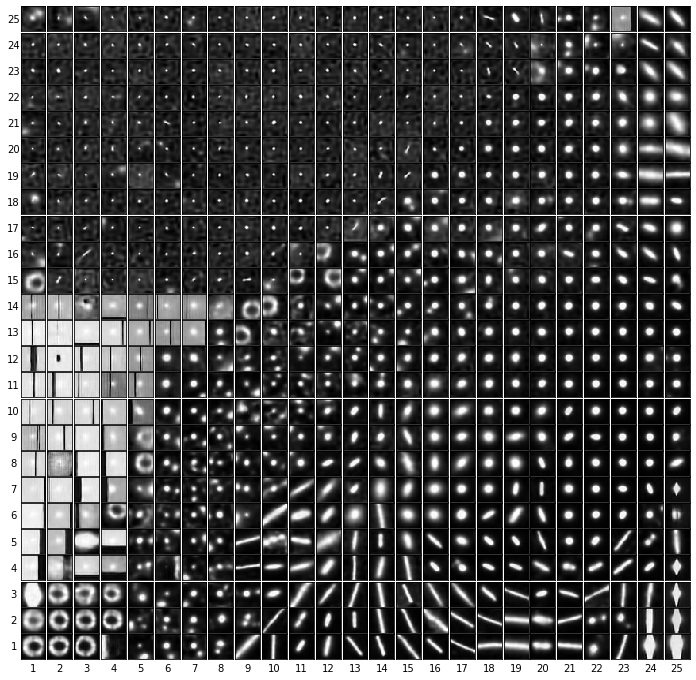

In [4]:
upper_lim = map_size[0] * map_size[1]
    
fig, ax = plt.subplots(map_size[0], map_size[1], figsize=(12,12))
xcount = 1
ycount = 25
for k in range(upper_lim):
    x = decoded_prototypes[k].reshape(input_dims, input_dims)
    ax[k // map_size[1]][k % map_size[1]].imshow(x, cmap='gray')
    ax[k // map_size[1]][k % map_size[1]].axes.xaxis.set_ticks([])
    ax[k // map_size[1]][k % map_size[1]].axes.yaxis.set_ticks([])
    if k // map_size[1]==24:
        ax[24][k % map_size[1]].set_xlabel(xcount)
        xcount+=1
    if k % map_size[1]==0:
        ax[k // map_size[1]][0].set_ylabel(ycount, labelpad=7, rotation='horizontal', va='center')
        ycount-=1
plt.subplots_adjust(hspace=0.05, wspace=0.05)

<h3><center>Generating histo-vectors</center></h3>

At this point DESOM-1 is set up and the trained model is imported. In the following, `small_test_set.npy` is loaded. It contains 150 lists. Each list contains data and metadata related to an exposure. By iterating through this data, each list is loaded as `tpm`. `X` is the first element of `tpm` which is the image data itself. The second is the exposure ID. `W`, is the weight associated with the data and `D` represents the number of dead CCDs in the ID.
    
At each iteration within the `for` loop, the trained DESOM-1 model is used to predict the relevant cell index for each object in `X`. This data is saved in `yhat` which is a list of predicted indices. Eventually, the histovector is calculated. This histovector data is used along with the associated weight to obtain the fingerprint data, `tp_fp`. Once this data is flattened and normalized, it is ready to be fed to DESOM-2. 

In [5]:
lst=np.load('data/small_test_set.npy', allow_pickle=True)

In [6]:
#A list of NODES
nodes_list = uti.generate_list_of_coords(map_size)
#Disctionaries for FAST conversion between a node index and its coordinate on the output map
node2idx = uti.get_idx_map(nodes_list, map_size)
idx2node = uti.get_node_map(map_size)



n_s =0
n_e =len(lst)
nf=1


tp_fp=[]
tp_id=[]
tp_de=[]


print('Generating histo-vectors for the 150 data samples...')
for k1 in range(n_s,n_e):
    try:
        if k1%1==0:
            print(k1, end=', ')
        tpm = lst[k1]
        X = np.array(tpm[0])
        W = tpm[2]
        D =tpm[3] 
        if len(X)>3600: W=int(W*(36/40.))

        len_data= len(np.where(np.isnan(X)==1)[0])
        if len_data==0:

            yhat = som.predict(np.reshape(X,(-1,input_dims*input_dims)))
            histovec = stan.get_bmu_counts(yhat, nodes_list, map_size, idx2node, node2idx)   
            Yh= np.reshape(histovec,(25,25)) 
            Yh= Yh.T

            tp_fp.append(np.round(W*Yh/3600.)) 
            tp_id.append(tpm[1])
            tp_de.append(D)        
        else:
            print('error')
            
    except:
        print('error two')
        pass
np.save('R_FP_test_'+str(nf),tp_fp)
np.save('R_ID_test_'+str(nf),tp_id)
np.save('R_DE_test_'+str(nf),tp_de)

tp_fp = np.array(tp_fp)
print()
print(np.shape(tp_fp), '--------------------------------------------')
print(np.shape(tp_id), '--------------------------------------------')
print ('Done')

idx_map: maps from NODE to IDX
node_map: maps from IDX to NODE
Generating histo-vectors for the 150 data samples...
0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 
(150, 25, 25) --------------------------------------------
(150,) --------------------------------------------
Done


The following part normalizes the histo-vectors using the same scaler function that was used during the training procedure. `x_test_normal` is a $(150, 625)$ matrix. This is the input to the trained DESOM-2 model. 

In [7]:
x_test = np.reshape(tp_fp, (n_e, 625))

for k1 in range(len(x_test)):
    h1=x_test[k1]
    sig= np.std(h1)
    mu=np.mean(h1)
    h1[h1>mu+3*sig]=mu+3*sig
    h1[h1<mu-.1*sig]=0
    x_test[k1]=h1
    
scaler_m=np.load('data/scaler_NormSA.npy',allow_pickle=True)[0]

x_test=x_test.T
scaler_s= preprocessing.StandardScaler().fit(x_test)
x_test= scaler_s.transform(x_test)
x_test=x_test.T

x_test_normal= scaler_m.transform(x_test)

<h3><center>Visualizing density map and histo-vectors</center></h3>

The graphs below show density maps and histo-vectors for two exposures.

Here we have two different exposures with different qualities and characteristics. The left panel represents density maps, i.e., the density of detected objects. We can also fatten the density maps and make a histo-vector for each exposure (the right panel). Each histo-vector, a one-dimensional distribution, can be considered a fngerprint of the exposure. As can be seen, the two IDs show different patterns (considering the density maps or, equivalently, the histo-vectors). For better content-based matching, each density map here should be compared to the previous graph (output map of DESOM-1 algorithm)

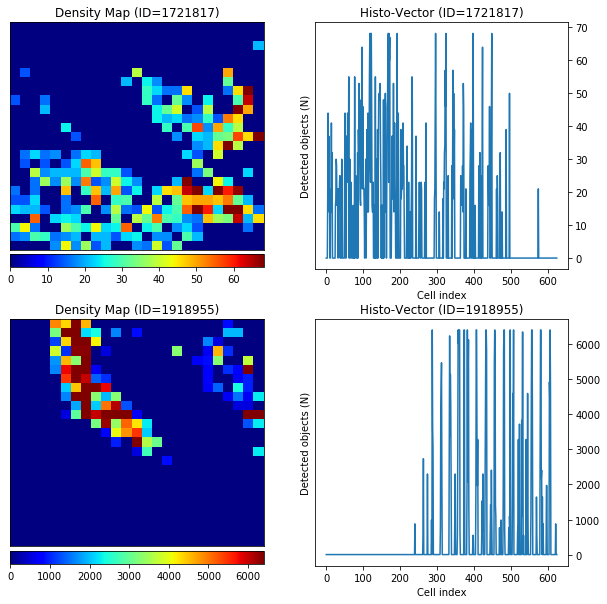

In [8]:
fig, ax = plt.subplots(2, 2, figsize=(10, 10))

selected_inds = [10, 130]

for i in range(2):
    im=ax[i, 0].pcolor(tp_fp[selected_inds[i]], cmap='jet')
    ax[i, 0].set(xticklabels=[])
    ax[i, 0].set(yticklabels=[])
    ax[i, 0].tick_params(bottom=False, left=False)
    ax[i, 0].set_title('Density Map (ID='+str(tp_id[selected_inds[i]])+')')
    plt.colorbar(im, orientation="horizontal", fraction=0.06, pad=0.02, ax=ax[i, 0])

    ax[i, 1].plot(np.reshape(tp_fp, (150, 625))[selected_inds[i]])
    ax[i, 1].set_title('Histo-Vector (ID='+str(tp_id[selected_inds[i]])+')')
    ax[i, 1].set_ylabel('Detected objects (N)')
    ax[i, 1].set_xlabel('Cell index')
    ax[i, 1].yaxis.tick_right()

Define the path to import trained DESOM-2 model results and weights. Import the trained DESOM-2 model. The structure below, shows the AutoEncode used in DESOM-2.

In [9]:
model2_path = os.path.join(root,'data/Models_NormSM_z100_it500kBlanced')
model2_path = os.path.join(model2_path, 'DESOM_model_final.h5')

In [10]:
fingerprint_dims=x_test_normal.shape[1]
map_size=(20,20)  # size of the DESOM-2 map
LATENT_DIMS = 100
gamma=.001
lr=2e-3

optimizer = optimizers.Adam(lr)


som2 = DESOM(input_dims= fingerprint_dims, map_size = map_size, latent_dims=LATENT_DIMS)
som2.initialize(ae_act ='relu', ae_init ='glorot_uniform')
som2.compile(gamma, optimizer)

som2.load_weights(model2_path)

Model: "autoencoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           (None, 625)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 450)               281700    
_________________________________________________________________
dense_3 (Dense)              (None, 300)               135300    
_________________________________________________________________
z (Dense)                    (None, 100)               30100     
_________________________________________________________________
decoder_2 (Dense)            (None, 300)               30300     
_________________________________________________________________
decoder_1 (Dense)            (None, 450)               135450    
_________________________________________________________________
decoder_0 (Dense)            (None, 625)               

Iterate through each histovector in the x_test_normal, use the trained DESOM-2 model in order to identify the best matching unit in the output map of DESOM-2 algorithm. `best_node` contains the index of the best matching unit for each histo-vector.

In [11]:
best_node=np.zeros((x_test_normal.shape[0]))
dist_map = get_distance_map(som2, x_test_normal)
for i in range(x_test_normal.shape[0]):        #for each fingerprint
    temp_dist_map=dist_map[i].flatten() # map_size[0]*map_size[1]
    temp_min=temp_dist_map.min()        # closest node
    best_node[i]=np.where(temp_dist_map == temp_min)[0] # bin closest node.

<h3><center>Output map of DESOM-2 algorithm</center></h3>

At this point, each exposure within the 150 list of IDs has passed through the trained DESOM-1 model. The density map and eventually the histo-vectors for each of the exposures are generated. Each histo-vector has passed through the trained DESOM-2 model in order to identify the index of the best matching unit on the DESOM-2 map.


To be able to easily access the exposure IDs within each cell on DESOM-2 map, `idmap` can be used. It is a dictionary whose keys are tuples of $x$ and $y$ coordinates on the DESOM-2 output map, and its values are list of exposure IDs within that cell. 

In [12]:
idmap = defaultdict(list)
for k, p in zip(best_node, tp_id):
    x = k // map_size[1]
    y = k % map_size[1]
    idmap[(int(x),int(y))].append(int(p))

In [13]:
# Members of all the cells are here:
idmap

defaultdict(list,
            {(2, 10): [1285889, 2067925, 1286724],
             (1, 0): [810404, 1723179, 862760],
             (9, 1): [2114182, 1786326, 1716671],
             (4, 13): [1942919],
             (8, 8): [947668],
             (3, 11): [1214886],
             (4, 0): [1166148],
             (9, 0): [979556],
             (1, 10): [1806518, 1652591, 2116383, 1584272, 2116428, 2104610],
             (8, 4): [1721817],
             (1, 8): [1119779, 1013754, 948302, 1122742, 1110914],
             (6, 2): [1927123],
             (2, 1): [1721860, 2100882, 2090952],
             (1, 2): [1257975],
             (8, 0): [1234970, 1021182, 839520],
             (1, 11): [2160167, 1205163, 1635652, 1790567, 1032898],
             (9, 3): [1926603],
             (3, 8): [2116477],
             (6, 3): [2158864],
             (2, 11): [1205605],
             (0, 10): [1705901],
             (2, 6): [2235886],
             (4, 3): [860197],
             (5, 2): [870722],
        

In [14]:
## For example, to see only members of cell (19, 19)
idmap[(19, 19)]

# Then you can use the CADC webpage to see the following ID (see below)

[1142601]

-----------------------------------------------------------------------------------------------------------------
To see IDs in the CADC webpage: Insert your desired ID into  the "Observation ID" bar, in the followiing page:

## https://www.cadc-ccda.hia-iha.nrc-cnrc.gc.ca/en/search/

For visualization purposes, we have imported the final DESOM-2 map as shown on Figure 9 on the paper. Figure 9 on the paper is generated by utilizing $\sim70k$ exposures. The 150 exposure IDs presented as a test set in this notebook file are represented by x sign on the map. To see what IDs belong to a given cell, use `idmap`.


In order to check what IDs belong to each cell in the entire $\sim70k$ exposures, use `all_idmap`.

In [15]:
all_idmap = np.load('data/all_id_map.npy', allow_pickle=True)[0]
DESOM2_map = np.load('data/DESOM2_map.npy')

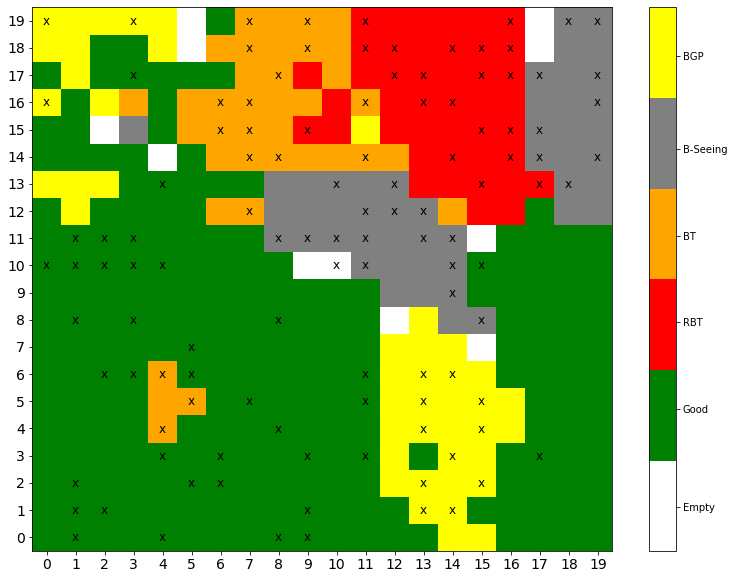

In [16]:
fig, ax = plt.subplots(figsize=(13,10))
cmap = mpl.colors.ListedColormap(['w', 'g', 'r', 'orange', 'gray', 'yellow'])
plt.pcolor(DESOM2_map.T, cmap=cmap)
cbar = plt.colorbar()
cbar.set_ticks([0.4, 1.3, 2.1, 2.9, 3.7, 4.55])
cbar.ax.set_yticklabels(['Empty', 'Good', 'RBT', 'BT', 'B-Seeing', 'BGP'])
plt.xticks(np.arange(0.5,20.5), np.arange(0,20),fontsize=14,rotation=0)  # Set text labels.
plt.yticks(np.arange(0.5,20.5), np.arange(0,20),fontsize=14,rotation=0)  # Set text labels.
for kk in idmap.keys():
    plt.text(kk[0]+0.35, kk[1]+0.35, 'x', fontsize=12)
print()

<h2><center>Conclusion</center></h2>


This paper aims to employ useful information taken from a MegaCam image (as the input to our pipeline) and
assign each image ID to a cell on DESOM-2. Similar images occupy one place on the map. In this way, we can cluster different images and then label them in a very efficient way.